# RBPF Pipeline Analysis

Compares Standard RBPF vs APF-enhanced pipeline across:
- Volatility tracking accuracy
- Regime detection performance
- Change detection (false positives/negatives)
- Latency distribution
- Scenario-specific behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Load data
df_std = pd.read_csv('rbpf_standard.csv')
df_apf = pd.read_csv('rbpf_apf.csv')
df_summary = pd.read_csv('rbpf_summary.csv')

print(f"Loaded {len(df_std)} ticks")
print(f"\nSummary metrics:")
display(df_summary)

Loaded 7000 ticks

Summary metrics:


,metric,standard,apf,improvement_pct
0,log_vol_rmse,0.330843,0.335827,-1.51
1,log_vol_mae,0.256838,0.259200,-0.92
2,log_vol_bias,0.041017,0.030107,26.60
3,vol_rmse,0.066395,0.066800,-0.61
4,vol_mae,0.027485,0.027596,-0.41
5,regime_accuracy,0.742571,0.710571,-4.31
6,detection_delay,2.047170,2.075472,-1.38
7,false_positives,536.000000,557.000000,-3.92
8,false_negatives,201.000000,202.000000,-0.50
9,true_positives,11.000000,10.000000,-9.09


## 1. Volatility Tracking

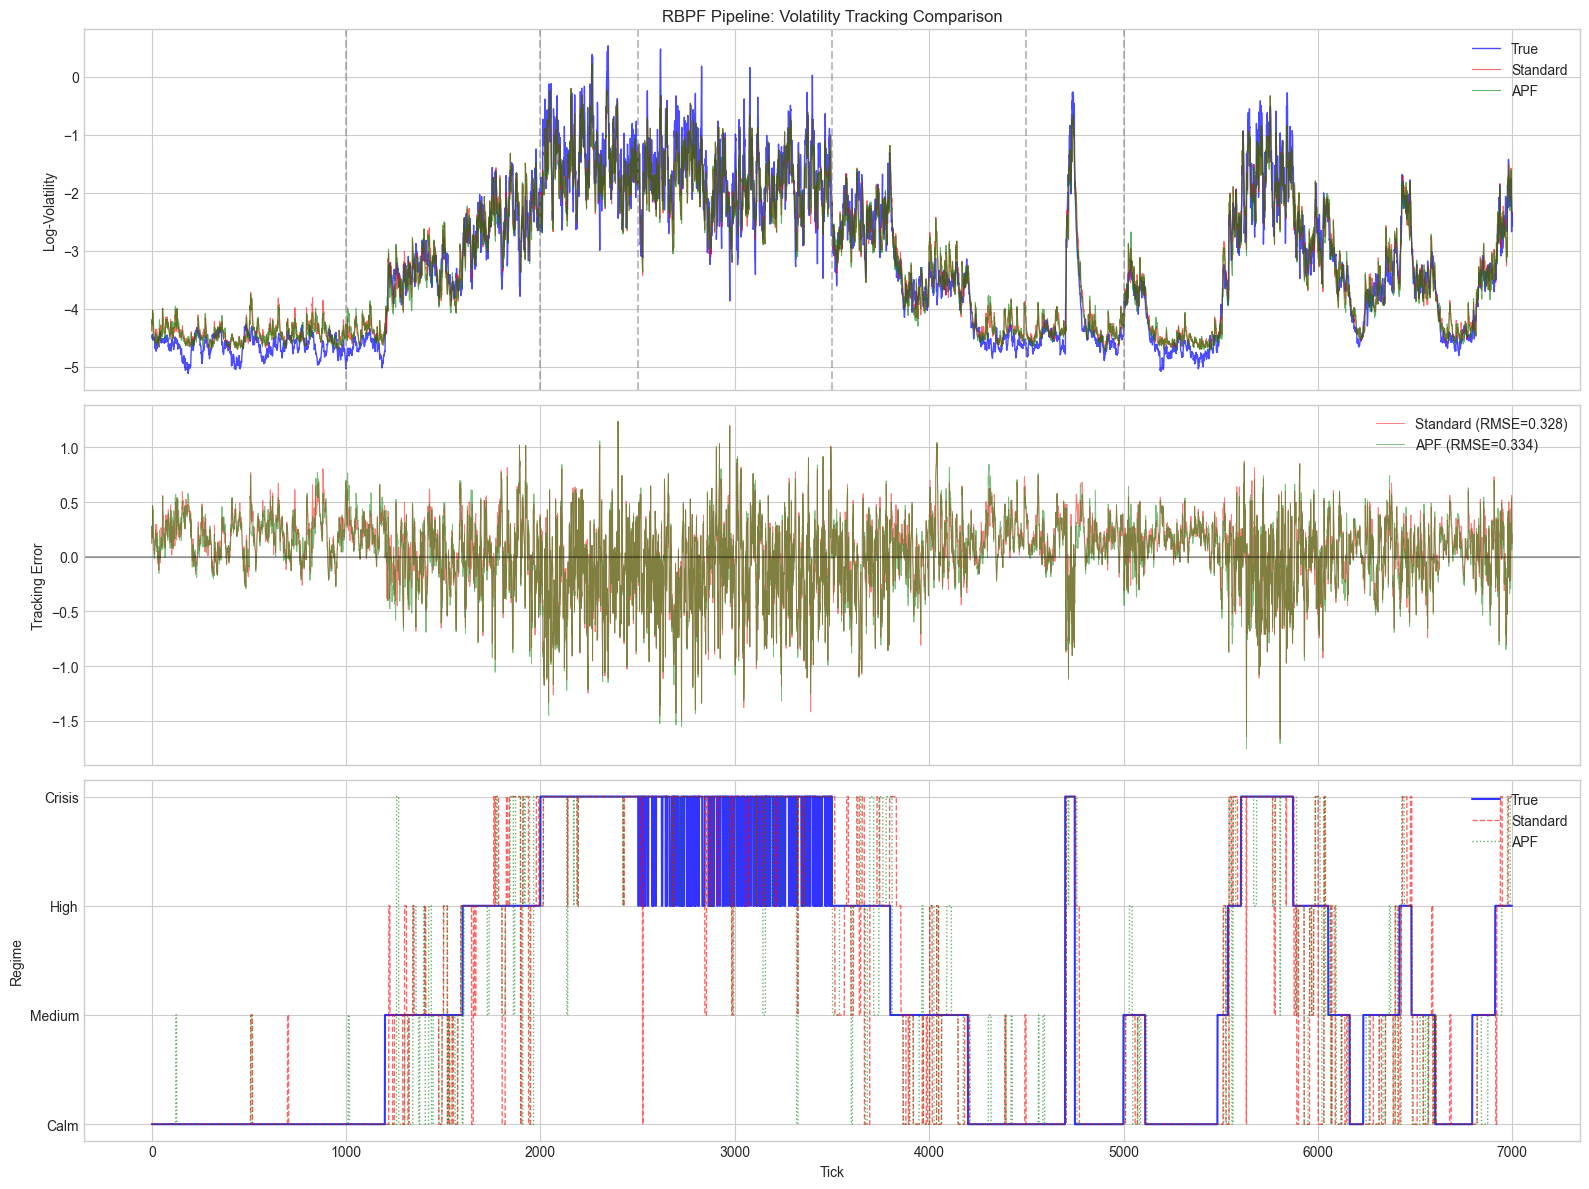

In [2]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Panel 1: Log-Volatility
ax = axes[0]
ax.plot(df_std['tick'], df_std['true_log_vol'], 'b-', alpha=0.7, label='True', linewidth=1)
ax.plot(df_std['tick'], df_std['est_log_vol'], 'r-', alpha=0.6, label='Standard', linewidth=0.8)
ax.plot(df_apf['tick'], df_apf['est_log_vol'], 'g-', alpha=0.6, label='APF', linewidth=0.8)
ax.set_ylabel('Log-Volatility')
ax.legend(loc='upper right')
ax.set_title('RBPF Pipeline: Volatility Tracking Comparison')

# Add scenario boundaries
scenario_bounds = [0, 1000, 2000, 2500, 3500, 4500, 5000, 7000]
for b in scenario_bounds[1:-1]:
    ax.axvline(b, color='gray', linestyle='--', alpha=0.5)

# Panel 2: Tracking Error
ax = axes[1]
err_std = df_std['est_log_vol'] - df_std['true_log_vol']
err_apf = df_apf['est_log_vol'] - df_apf['true_log_vol']
ax.plot(df_std['tick'], err_std, 'r-', alpha=0.5, label=f'Standard (RMSE={err_std.std():.3f})', linewidth=0.7)
ax.plot(df_apf['tick'], err_apf, 'g-', alpha=0.5, label=f'APF (RMSE={err_apf.std():.3f})', linewidth=0.7)
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_ylabel('Tracking Error')
ax.legend(loc='upper right')

# Panel 3: Regime
ax = axes[2]
ax.plot(df_std['tick'], df_std['true_regime'], 'b-', alpha=0.8, label='True', linewidth=1.5)
ax.plot(df_std['tick'], df_std['est_regime_smooth'], 'r--', alpha=0.6, label='Standard', linewidth=1)
ax.plot(df_apf['tick'], df_apf['est_regime_smooth'], 'g:', alpha=0.6, label='APF', linewidth=1)
ax.set_ylabel('Regime')
ax.set_xlabel('Tick')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['Calm', 'Medium', 'High', 'Crisis'])
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('rbpf_volatility_tracking.png', dpi=150)
plt.show()

## 2. Regime Detection Deep Dive

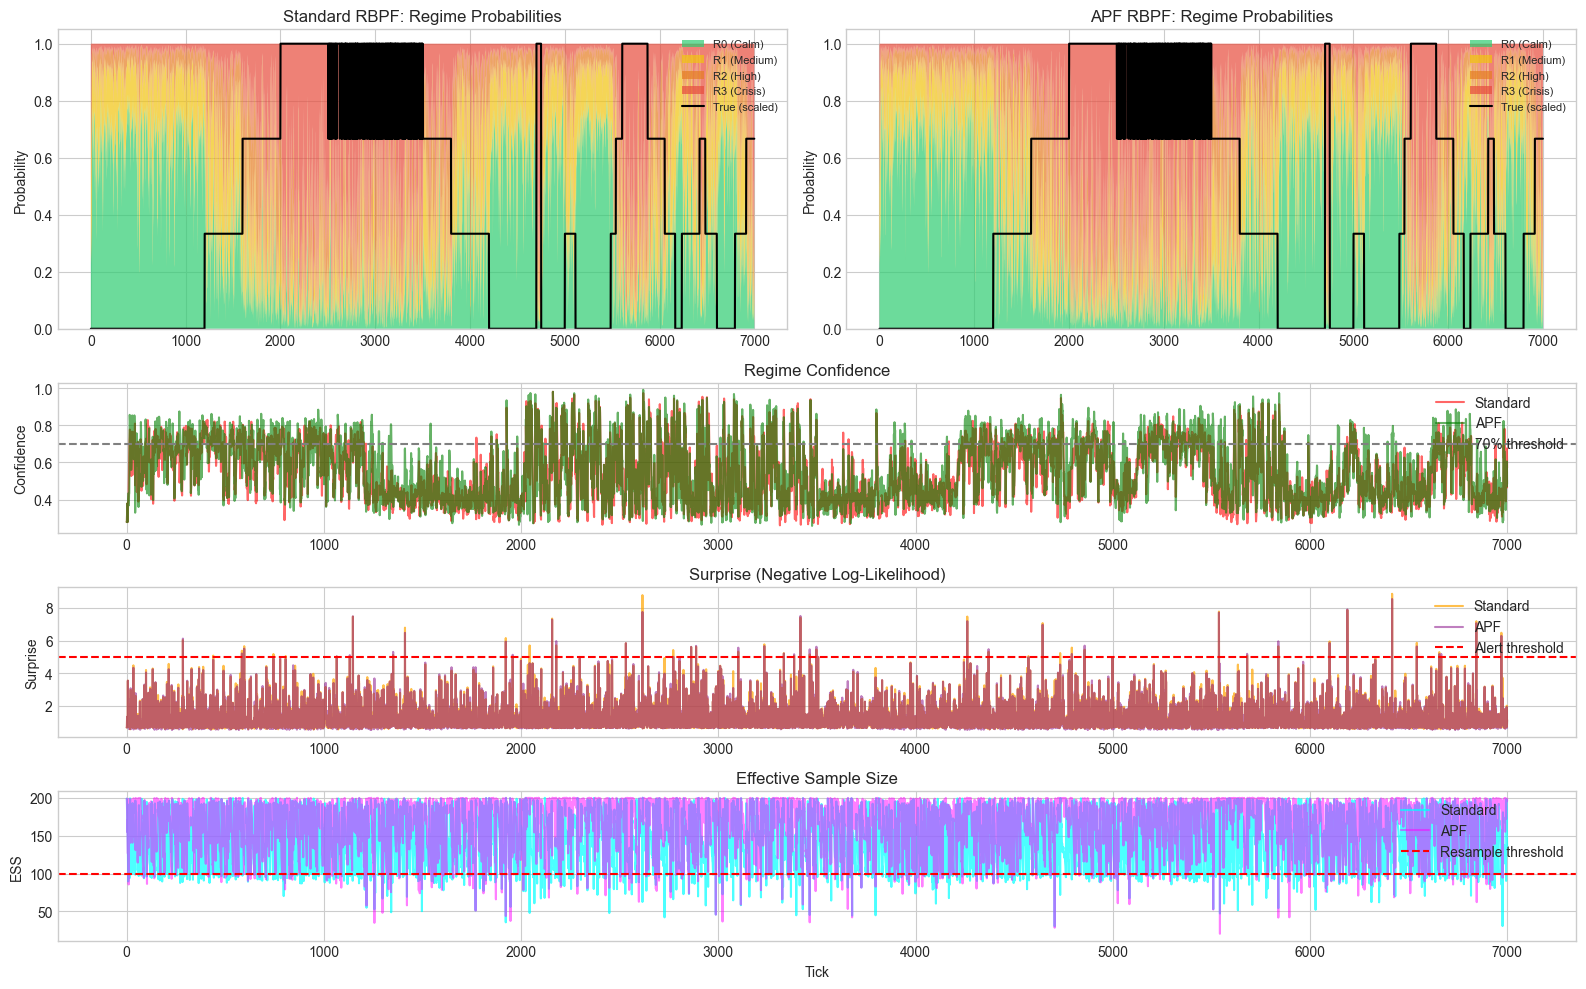

In [3]:
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(4, 2, figure=fig, height_ratios=[2, 1, 1, 1])

# Top: Full regime probabilities (Standard)
ax = fig.add_subplot(gs[0, 0])
ax.stackplot(df_std['tick'], 
             df_std['regime_prob_0'], df_std['regime_prob_1'],
             df_std['regime_prob_2'], df_std['regime_prob_3'],
             labels=['R0 (Calm)', 'R1 (Medium)', 'R2 (High)', 'R3 (Crisis)'],
             colors=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
             alpha=0.7)
ax.plot(df_std['tick'], df_std['true_regime'] / 3.0, 'k-', linewidth=1.5, label='True (scaled)')
ax.set_ylabel('Probability')
ax.set_title('Standard RBPF: Regime Probabilities')
ax.legend(loc='upper right', fontsize=8)

# Top: Full regime probabilities (APF)
ax = fig.add_subplot(gs[0, 1])
ax.stackplot(df_apf['tick'], 
             df_apf['regime_prob_0'], df_apf['regime_prob_1'],
             df_apf['regime_prob_2'], df_apf['regime_prob_3'],
             labels=['R0 (Calm)', 'R1 (Medium)', 'R2 (High)', 'R3 (Crisis)'],
             colors=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
             alpha=0.7)
ax.plot(df_apf['tick'], df_apf['true_regime'] / 3.0, 'k-', linewidth=1.5, label='True (scaled)')
ax.set_ylabel('Probability')
ax.set_title('APF RBPF: Regime Probabilities')
ax.legend(loc='upper right', fontsize=8)

# Confidence comparison
ax = fig.add_subplot(gs[1, :])
ax.plot(df_std['tick'], df_std['regime_confidence'], 'r-', alpha=0.6, label='Standard')
ax.plot(df_apf['tick'], df_apf['regime_confidence'], 'g-', alpha=0.6, label='APF')
ax.axhline(0.7, color='gray', linestyle='--', label='70% threshold')
ax.set_ylabel('Confidence')
ax.legend(loc='upper right')
ax.set_title('Regime Confidence')

# Surprise
ax = fig.add_subplot(gs[2, :])
ax.plot(df_std['tick'], df_std['surprise'], 'orange', alpha=0.7, label='Standard')
ax.plot(df_apf['tick'], df_apf['surprise'], 'purple', alpha=0.5, label='APF')
ax.axhline(5.0, color='red', linestyle='--', label='Alert threshold')
ax.set_ylabel('Surprise')
ax.legend(loc='upper right')
ax.set_title('Surprise (Negative Log-Likelihood)')

# ESS
ax = fig.add_subplot(gs[3, :])
ax.plot(df_std['tick'], df_std['ess'], 'cyan', alpha=0.7, label='Standard')
ax.plot(df_apf['tick'], df_apf['ess'], 'magenta', alpha=0.5, label='APF')
ax.axhline(100, color='red', linestyle='--', label='Resample threshold')
ax.set_ylabel('ESS')
ax.set_xlabel('Tick')
ax.legend(loc='upper right')
ax.set_title('Effective Sample Size')

plt.tight_layout()
plt.savefig('rbpf_regime_detection.png', dpi=150)
plt.show()

### 2.1 Regime Confidence (Detailed View)

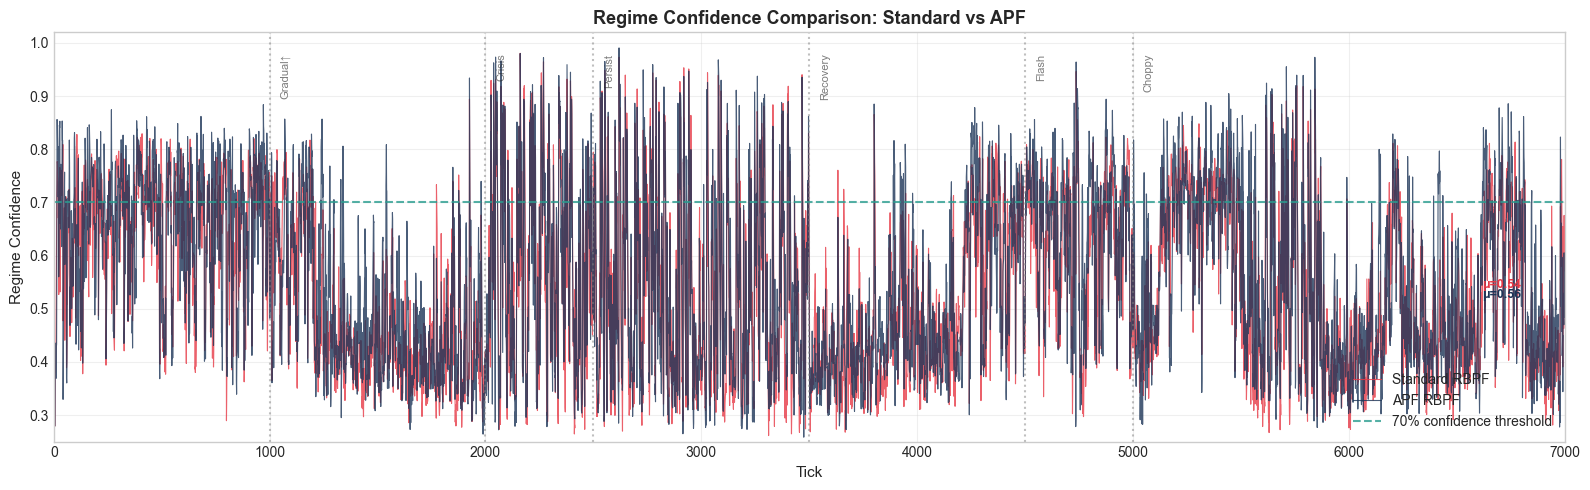


Regime Confidence Statistics:
Metric                        Standard          APF
--------------------------------------------------
Mean confidence                  0.544        0.557
Std deviation                    0.154        0.160
% above 70%                      21.1%        24.0%
Min confidence                   0.261        0.258


In [4]:
# Standalone Regime Confidence plot - zoomed and clearer
fig, ax = plt.subplots(figsize=(16, 5))

# Plot with distinct colors: Red for Standard, Blue for APF
ax.plot(df_std['tick'], df_std['regime_confidence'], 
        color='#E63946', alpha=0.8, linewidth=0.8, label='Standard RBPF')
ax.plot(df_apf['tick'], df_apf['regime_confidence'], 
        color='#1D3557', alpha=0.8, linewidth=0.8, label='APF RBPF')

# Reference threshold
ax.axhline(0.7, color='#2A9D8F', linestyle='--', linewidth=1.5, 
           label='70% confidence threshold', alpha=0.8)

# Scenario boundaries
scenario_bounds = [1000, 2000, 2500, 3500, 4500, 5000]
scenario_names = ['Gradual↑', 'Crisis', 'Persist', 'Recovery', 'Flash', 'Choppy']
for i, b in enumerate(scenario_bounds):
    ax.axvline(b, color='gray', linestyle=':', alpha=0.5)
    if i < len(scenario_names):
        ax.text(b + 50, 0.98, scenario_names[i], fontsize=8, 
                rotation=90, va='top', alpha=0.6)

# Formatting
ax.set_xlabel('Tick', fontsize=11)
ax.set_ylabel('Regime Confidence', fontsize=11)
ax.set_title('Regime Confidence Comparison: Standard vs APF', fontsize=13, fontweight='bold')
ax.set_ylim(0.25, 1.02)
ax.set_xlim(0, 7000)
ax.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Add mean confidence annotations
mean_std = df_std['regime_confidence'].mean()
mean_apf = df_apf['regime_confidence'].mean()
ax.text(6800, mean_std, f'μ={mean_std:.2f}', color='#E63946', 
        fontsize=9, va='center', ha='right', fontweight='bold')
ax.text(6800, mean_apf - 0.03, f'μ={mean_apf:.2f}', color='#1D3557', 
        fontsize=9, va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.savefig('rbpf_regime_confidence.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\nRegime Confidence Statistics:")
print(f"{'Metric':<25} {'Standard':>12} {'APF':>12}")
print("-" * 50)
print(f"{'Mean confidence':<25} {mean_std:>12.3f} {mean_apf:>12.3f}")
print(f"{'Std deviation':<25} {df_std['regime_confidence'].std():>12.3f} {df_apf['regime_confidence'].std():>12.3f}")
print(f"{'% above 70%':<25} {(df_std['regime_confidence'] > 0.7).mean()*100:>11.1f}% {(df_apf['regime_confidence'] > 0.7).mean()*100:>11.1f}%")
print(f"{'Min confidence':<25} {df_std['regime_confidence'].min():>12.3f} {df_apf['regime_confidence'].min():>12.3f}")

## 3. Change Detection Performance

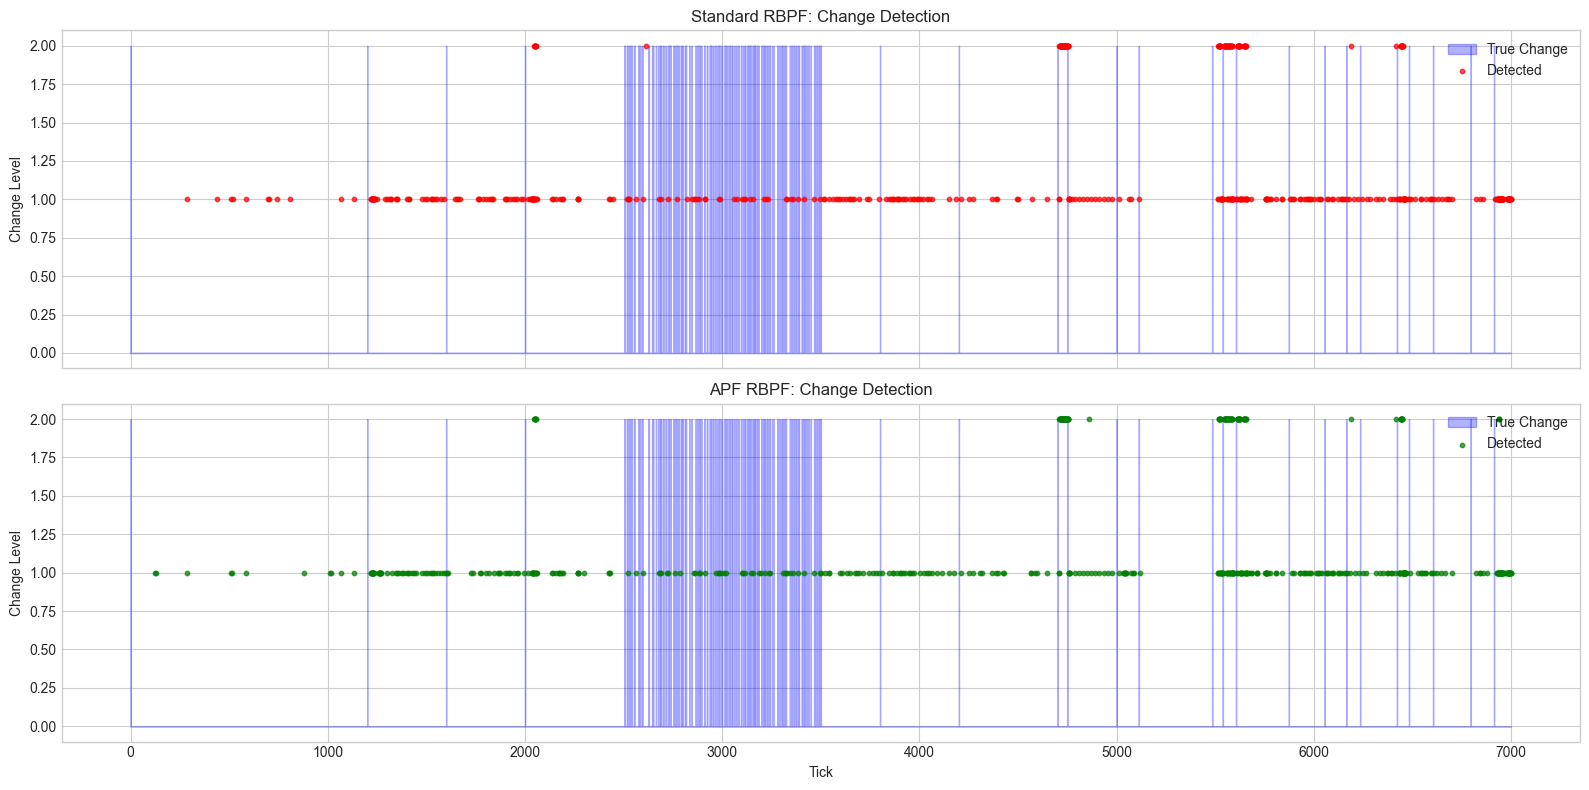


Change Detection Statistics:

Standard:
  True Positives:  11
  False Positives: 536
  False Negatives: 202
  Precision: 0.020
  Recall:    0.052
  F1 Score:  0.029

APF:
  True Positives:  10
  False Positives: 557
  False Negatives: 203
  Precision: 0.018
  Recall:    0.047
  F1 Score:  0.026


In [5]:
# Identify true regime changes
df_std['true_change'] = (df_std['true_regime'].diff() != 0).astype(int)
df_apf['true_change'] = (df_apf['true_regime'].diff() != 0).astype(int)

# Mark detected changes
df_std['detected'] = (df_std['change_detected'] > 0).astype(int)
df_apf['detected'] = (df_apf['change_detected'] > 0).astype(int)

fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Standard
ax = axes[0]
ax.fill_between(df_std['tick'], 0, df_std['true_change'] * 2, 
                alpha=0.3, color='blue', label='True Change', step='mid')
ax.scatter(df_std[df_std['detected'] == 1]['tick'], 
           df_std[df_std['detected'] == 1]['change_detected'],
           c='red', s=10, alpha=0.7, label='Detected')
ax.set_ylabel('Change Level')
ax.set_title('Standard RBPF: Change Detection')
ax.legend(loc='upper right')

# APF
ax = axes[1]
ax.fill_between(df_apf['tick'], 0, df_apf['true_change'] * 2, 
                alpha=0.3, color='blue', label='True Change', step='mid')
ax.scatter(df_apf[df_apf['detected'] == 1]['tick'], 
           df_apf[df_apf['detected'] == 1]['change_detected'],
           c='green', s=10, alpha=0.7, label='Detected')
ax.set_ylabel('Change Level')
ax.set_xlabel('Tick')
ax.set_title('APF RBPF: Change Detection')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('rbpf_change_detection.png', dpi=150)
plt.show()

# Confusion matrix style analysis
print("\nChange Detection Statistics:")
print("=" * 50)
for name, df in [('Standard', df_std), ('APF', df_apf)]:
    tp = ((df['true_change'] == 1) & (df['detected'] == 1)).sum()
    fp = ((df['true_change'] == 0) & (df['detected'] == 1)).sum()
    fn = ((df['true_change'] == 1) & (df['detected'] == 0)).sum()
    tn = ((df['true_change'] == 0) & (df['detected'] == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{name}:")
    print(f"  True Positives:  {tp}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1 Score:  {f1:.3f}")

## 4. Latency Analysis

C:\Users\Tugbars\AppData\Local\Temp\ipykernel_37632\506906377.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_box, labels=['Standard', 'APF'], patch_artist=True)


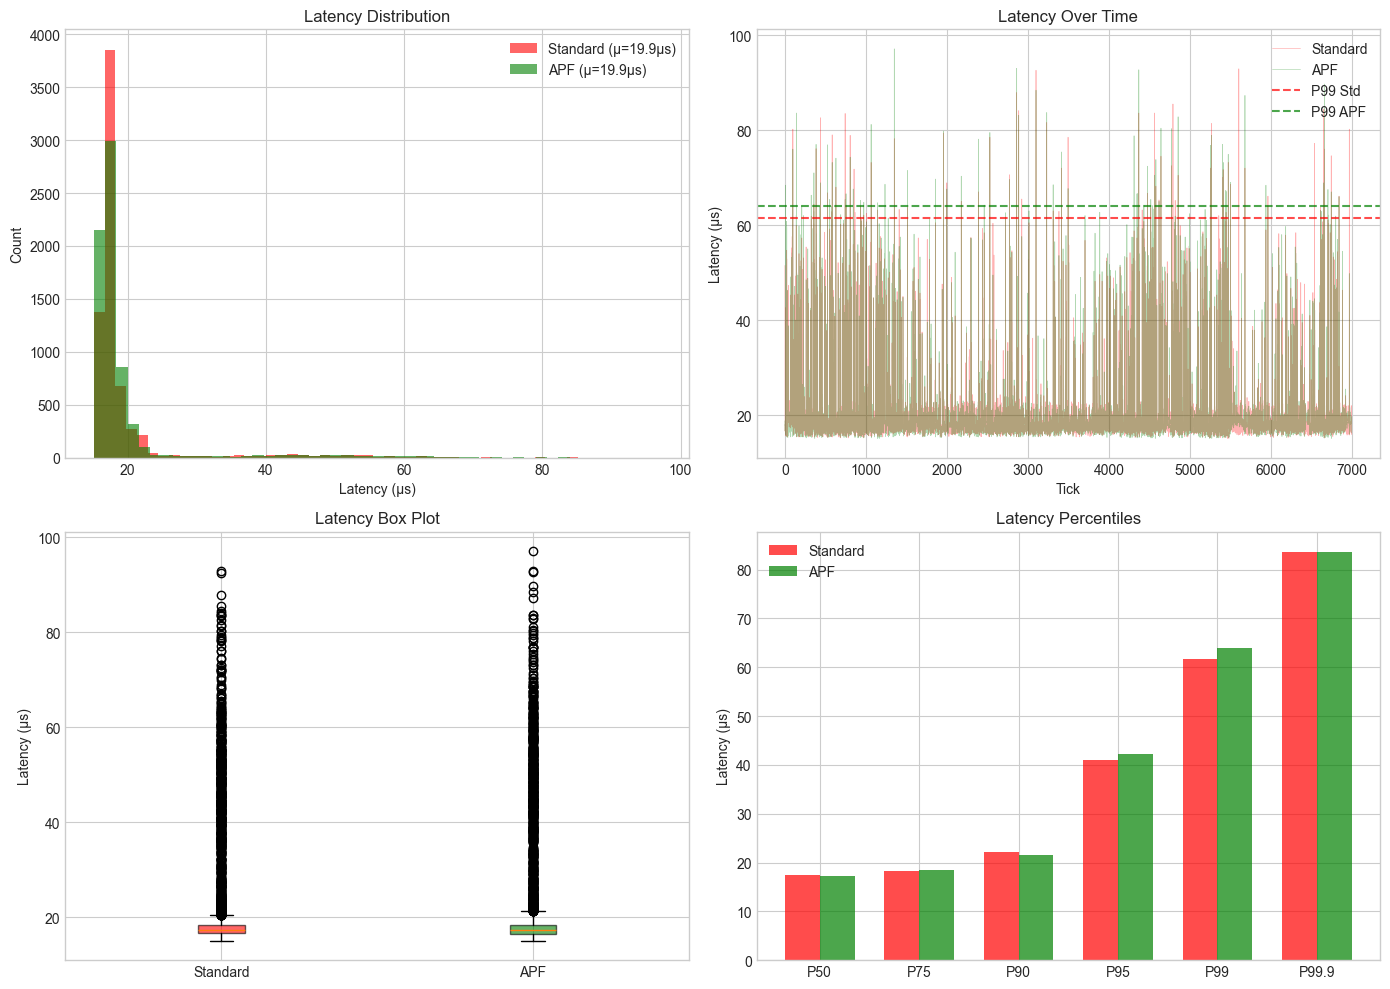


Latency Statistics:

Standard:
  Mean:   19.88 μs
  Median: 17.40 μs
  Std:    8.80 μs
  P95:    40.90 μs
  P99:    61.60 μs
  Max:    92.90 μs

APF:
  Mean:   19.88 μs
  Median: 17.30 μs
  Std:    9.21 μs
  P95:    42.30 μs
  P99:    64.00 μs
  Max:    97.10 μs


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram comparison
ax = axes[0, 0]
ax.hist(df_std['latency_us'], bins=50, alpha=0.6, label=f"Standard (μ={df_std['latency_us'].mean():.1f}μs)", color='red')
ax.hist(df_apf['latency_us'], bins=50, alpha=0.6, label=f"APF (μ={df_apf['latency_us'].mean():.1f}μs)", color='green')
ax.set_xlabel('Latency (μs)')
ax.set_ylabel('Count')
ax.set_title('Latency Distribution')
ax.legend()

# Latency over time
ax = axes[0, 1]
ax.plot(df_std['tick'], df_std['latency_us'], 'r-', alpha=0.3, linewidth=0.5, label='Standard')
ax.plot(df_apf['tick'], df_apf['latency_us'], 'g-', alpha=0.3, linewidth=0.5, label='APF')
ax.axhline(df_std['latency_us'].quantile(0.99), color='red', linestyle='--', alpha=0.7, label='P99 Std')
ax.axhline(df_apf['latency_us'].quantile(0.99), color='green', linestyle='--', alpha=0.7, label='P99 APF')
ax.set_xlabel('Tick')
ax.set_ylabel('Latency (μs)')
ax.set_title('Latency Over Time')
ax.legend()

# Box plot
ax = axes[1, 0]
data_box = [df_std['latency_us'], df_apf['latency_us']]
bp = ax.boxplot(data_box, labels=['Standard', 'APF'], patch_artist=True)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][1].set_facecolor('green')
for box in bp['boxes']:
    box.set_alpha(0.6)
ax.set_ylabel('Latency (μs)')
ax.set_title('Latency Box Plot')

# Percentile comparison
ax = axes[1, 1]
percentiles = [50, 75, 90, 95, 99, 99.9]
std_p = [np.percentile(df_std['latency_us'], p) for p in percentiles]
apf_p = [np.percentile(df_apf['latency_us'], p) for p in percentiles]
x = np.arange(len(percentiles))
width = 0.35
ax.bar(x - width/2, std_p, width, label='Standard', color='red', alpha=0.7)
ax.bar(x + width/2, apf_p, width, label='APF', color='green', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels([f'P{p}' for p in percentiles])
ax.set_ylabel('Latency (μs)')
ax.set_title('Latency Percentiles')
ax.legend()

plt.tight_layout()
plt.savefig('rbpf_latency.png', dpi=150)
plt.show()

print("\nLatency Statistics:")
print("=" * 50)
for name, df in [('Standard', df_std), ('APF', df_apf)]:
    lat = df['latency_us']
    print(f"\n{name}:")
    print(f"  Mean:   {lat.mean():.2f} μs")
    print(f"  Median: {lat.median():.2f} μs")
    print(f"  Std:    {lat.std():.2f} μs")
    print(f"  P95:    {lat.quantile(0.95):.2f} μs")
    print(f"  P99:    {lat.quantile(0.99):.2f} μs")
    print(f"  Max:    {lat.max():.2f} μs")

## 5. Scenario-Specific Analysis

In [7]:
# Define scenarios
scenarios = [
    ('1. Calm', 0, 1000),
    ('2. Gradual Increase', 1000, 2000),
    ('3. Sudden Crisis', 2000, 2500),
    ('4. Crisis Persistence', 2500, 3500),
    ('5. Recovery', 3500, 4500),
    ('6. Flash Crash', 4500, 5000),
    ('7. Choppy', 5000, 7000)
]

# Compute metrics per scenario
results = []
for name, start, end in scenarios:
    mask = (df_std['tick'] >= start) & (df_std['tick'] < end)
    
    std_slice = df_std[mask]
    apf_slice = df_apf[mask]
    
    # Regime accuracy
    std_acc = (std_slice['est_regime_smooth'] == std_slice['true_regime']).mean()
    apf_acc = (apf_slice['est_regime_smooth'] == apf_slice['true_regime']).mean()
    
    # Vol RMSE
    std_rmse = np.sqrt(((std_slice['est_log_vol'] - std_slice['true_log_vol'])**2).mean())
    apf_rmse = np.sqrt(((apf_slice['est_log_vol'] - apf_slice['true_log_vol'])**2).mean())
    
    # Latency
    std_lat = std_slice['latency_us'].mean()
    apf_lat = apf_slice['latency_us'].mean()
    
    results.append({
        'Scenario': name,
        'Std Acc': f"{std_acc*100:.1f}%",
        'APF Acc': f"{apf_acc*100:.1f}%",
        'Std RMSE': f"{std_rmse:.3f}",
        'APF RMSE': f"{apf_rmse:.3f}",
        'Std Lat': f"{std_lat:.1f}μs",
        'APF Lat': f"{apf_lat:.1f}μs"
    })

df_results = pd.DataFrame(results)
print("\nScenario-Specific Performance:")
print("=" * 80)
display(df_results)


Scenario-Specific Performance:


,Scenario,Std Acc,APF Acc,Std RMSE,APF RMSE,Std Lat,APF Lat
0,1. Calm,98.5%,99.0%,0.280,0.271,21.5μs,21.2μs
1,2. Gradual Increase,66.6%,54.5%,0.296,0.318,19.8μs,19.9μs
2,3. Sudden Crisis,94.0%,93.4%,0.451,0.458,18.5μs,18.7μs
3,4. Crisis Persistence,64.9%,63.5%,0.447,0.453,19.1μs,19.0μs
4,5. Recovery,57.9%,57.1%,0.312,0.318,19.6μs,19.6μs
5,6. Flash Crash,94.2%,94.0%,0.290,0.276,21.4μs,21.4μs
6,7. Choppy,68.9%,64.8%,0.282,0.288,19.6μs,19.7μs


## 6. Position Scaling Analysis

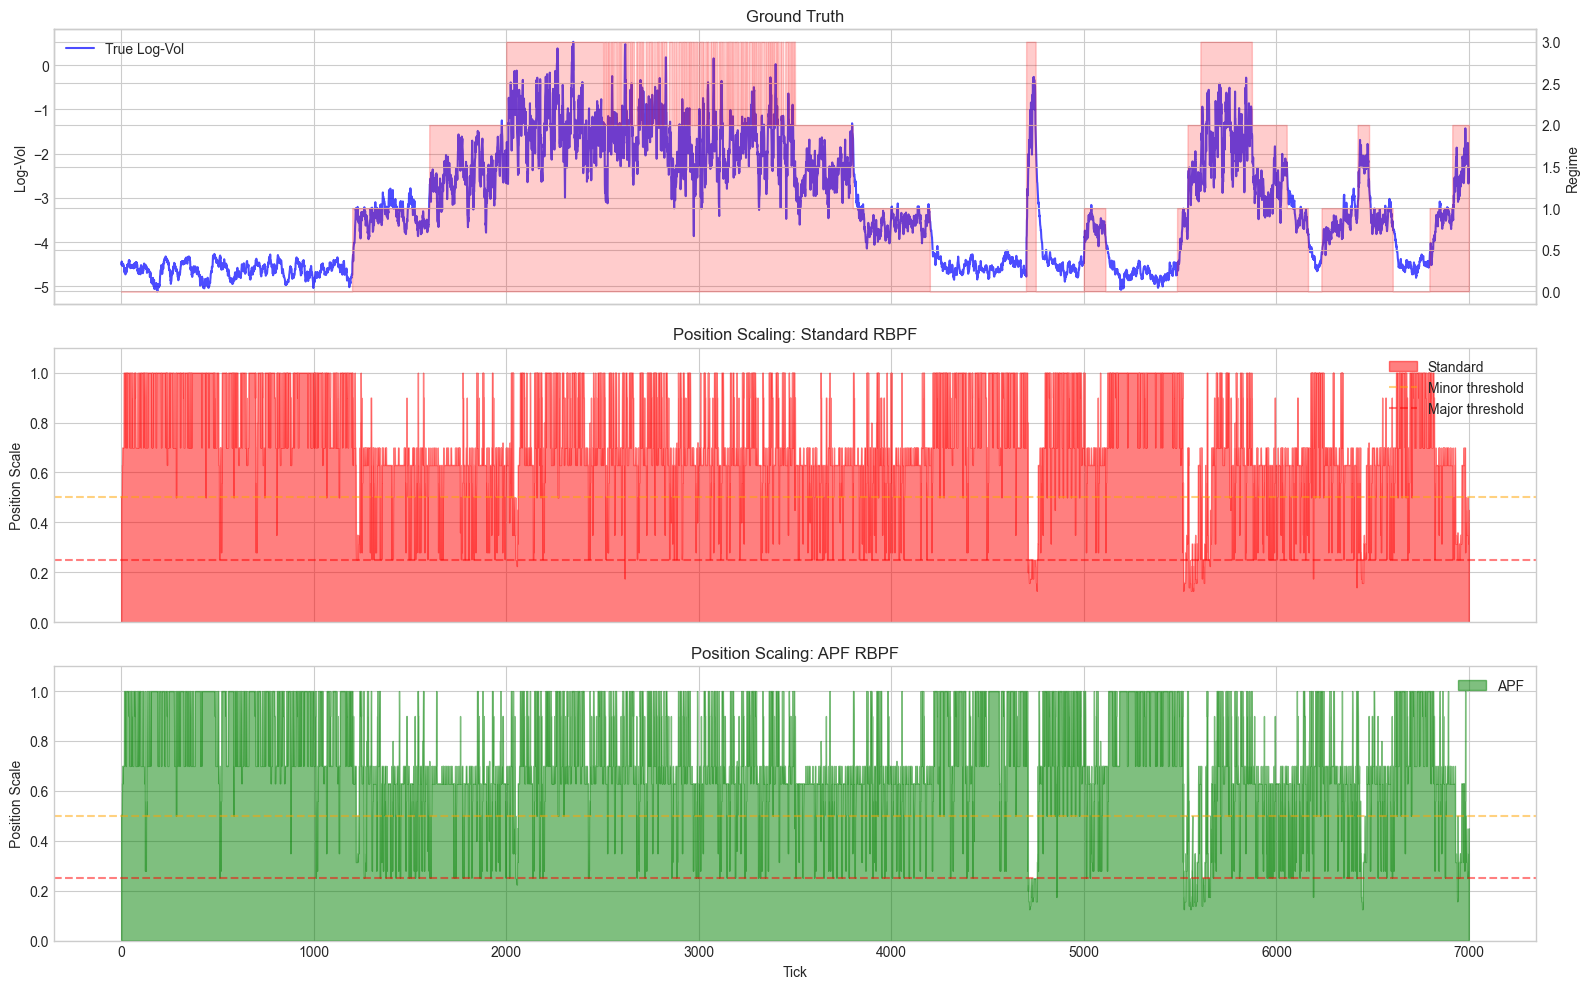


Average Position Scale by True Regime:
  Regime 0 (Calm): Standard=0.899, APF=0.896
  Regime 1 (Medium): Standard=0.638, APF=0.656
  Regime 2 (High): Standard=0.610, APF=0.616
  Regime 3 (Crisis): Standard=0.727, APF=0.731


In [8]:
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# True regime + volatility
ax = axes[0]
ax.plot(df_std['tick'], df_std['true_log_vol'], 'b-', alpha=0.7, label='True Log-Vol')
ax2 = ax.twinx()
ax2.fill_between(df_std['tick'], 0, df_std['true_regime'], alpha=0.2, color='red', label='True Regime')
ax.set_ylabel('Log-Vol')
ax2.set_ylabel('Regime')
ax.set_title('Ground Truth')
ax.legend(loc='upper left')

# Position scale (Standard)
ax = axes[1]
ax.fill_between(df_std['tick'], 0, df_std['position_scale'], alpha=0.5, color='red', label='Standard')
ax.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='Minor threshold')
ax.axhline(0.25, color='red', linestyle='--', alpha=0.5, label='Major threshold')
ax.set_ylabel('Position Scale')
ax.set_ylim(0, 1.1)
ax.set_title('Position Scaling: Standard RBPF')
ax.legend(loc='upper right')

# Position scale (APF)
ax = axes[2]
ax.fill_between(df_apf['tick'], 0, df_apf['position_scale'], alpha=0.5, color='green', label='APF')
ax.axhline(0.5, color='orange', linestyle='--', alpha=0.5)
ax.axhline(0.25, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('Position Scale')
ax.set_xlabel('Tick')
ax.set_ylim(0, 1.1)
ax.set_title('Position Scaling: APF RBPF')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('rbpf_position_scaling.png', dpi=150)
plt.show()

# Position scale statistics by true regime
print("\nAverage Position Scale by True Regime:")
print("=" * 50)
for regime in [0, 1, 2, 3]:
    mask = df_std['true_regime'] == regime
    std_scale = df_std[mask]['position_scale'].mean()
    apf_scale = df_apf[mask]['position_scale'].mean()
    regime_names = ['Calm', 'Medium', 'High', 'Crisis']
    print(f"  Regime {regime} ({regime_names[regime]}): Standard={std_scale:.3f}, APF={apf_scale:.3f}")

## 7. Zoom: Flash Crash Scenario

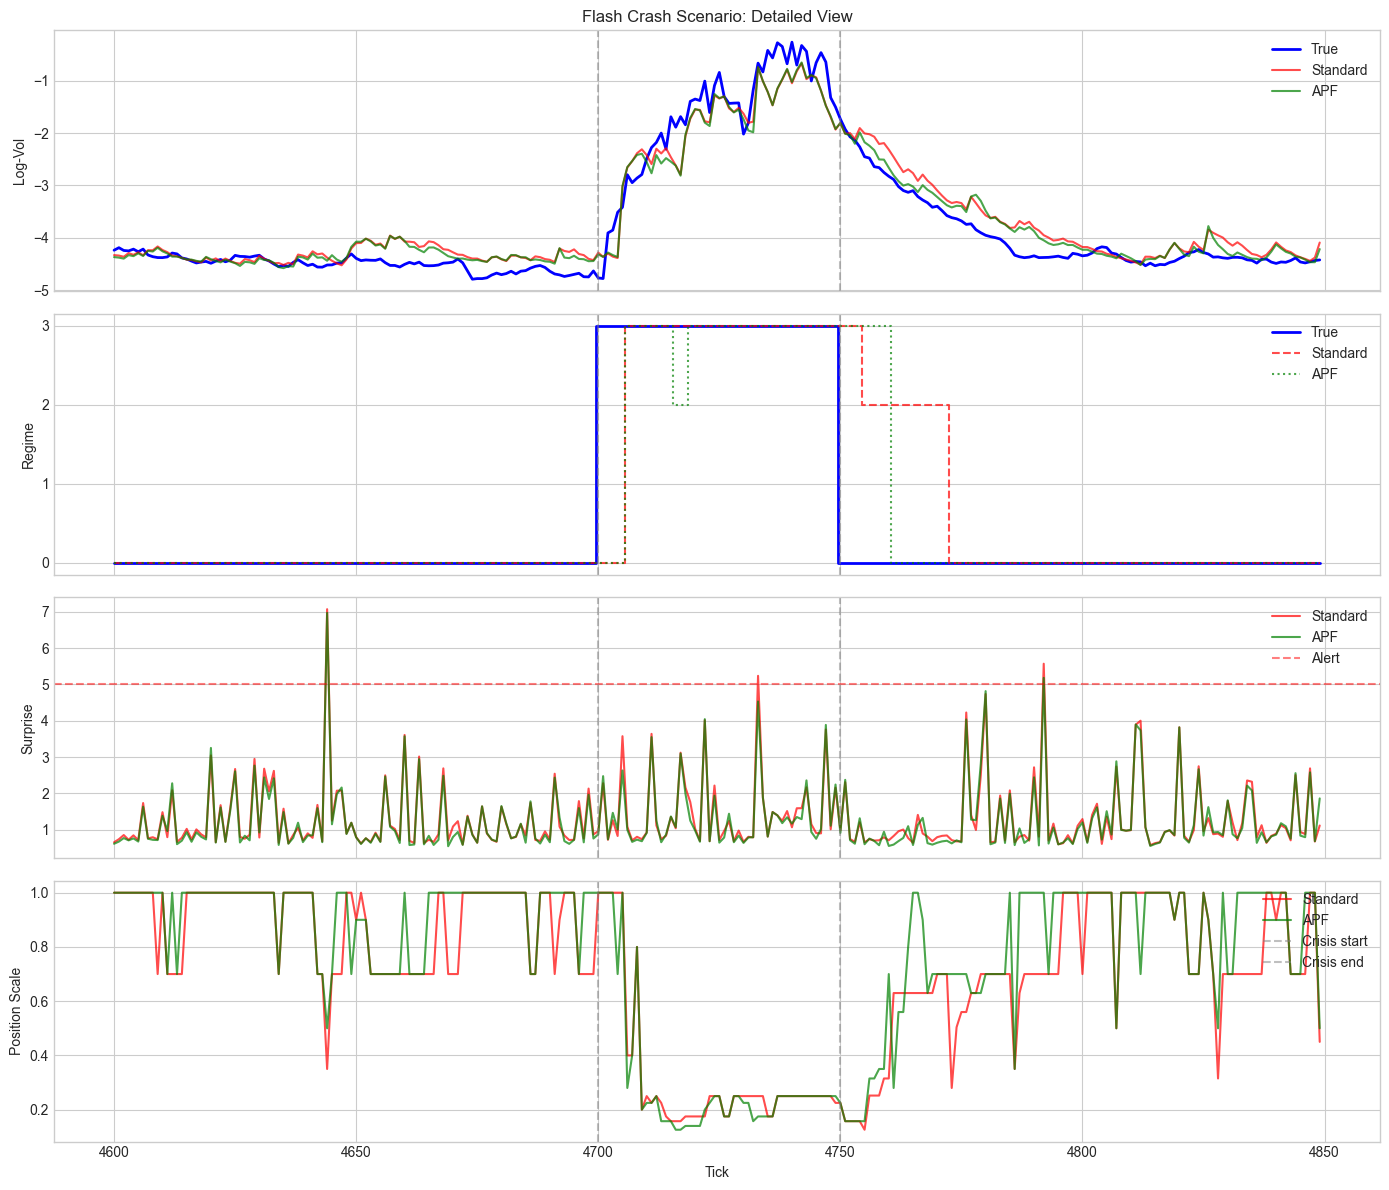

In [9]:
# Focus on flash crash (4500-5000)
start, end = 4600, 4850
mask = (df_std['tick'] >= start) & (df_std['tick'] < end)

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Vol
ax = axes[0]
ax.plot(df_std[mask]['tick'], df_std[mask]['true_log_vol'], 'b-', linewidth=2, label='True')
ax.plot(df_std[mask]['tick'], df_std[mask]['est_log_vol'], 'r-', alpha=0.7, label='Standard')
ax.plot(df_apf[mask]['tick'], df_apf[mask]['est_log_vol'], 'g-', alpha=0.7, label='APF')
ax.set_ylabel('Log-Vol')
ax.axvline(4700, color='gray', linestyle='--', alpha=0.5)
ax.axvline(4750, color='gray', linestyle='--', alpha=0.5)
ax.legend(loc='upper right')
ax.set_title('Flash Crash Scenario: Detailed View')

# Regime
ax = axes[1]
ax.step(df_std[mask]['tick'], df_std[mask]['true_regime'], 'b-', where='mid', linewidth=2, label='True')
ax.step(df_std[mask]['tick'], df_std[mask]['est_regime_smooth'], 'r--', where='mid', alpha=0.7, label='Standard')
ax.step(df_apf[mask]['tick'], df_apf[mask]['est_regime_smooth'], 'g:', where='mid', alpha=0.7, label='APF')
ax.set_ylabel('Regime')
ax.set_yticks([0, 1, 2, 3])
ax.axvline(4700, color='gray', linestyle='--', alpha=0.5)
ax.axvline(4750, color='gray', linestyle='--', alpha=0.5)
ax.legend(loc='upper right')

# Surprise
ax = axes[2]
ax.plot(df_std[mask]['tick'], df_std[mask]['surprise'], 'r-', alpha=0.7, label='Standard')
ax.plot(df_apf[mask]['tick'], df_apf[mask]['surprise'], 'g-', alpha=0.7, label='APF')
ax.axhline(5.0, color='red', linestyle='--', alpha=0.5, label='Alert')
ax.set_ylabel('Surprise')
ax.axvline(4700, color='gray', linestyle='--', alpha=0.5)
ax.axvline(4750, color='gray', linestyle='--', alpha=0.5)
ax.legend(loc='upper right')

# Position scale
ax = axes[3]
ax.plot(df_std[mask]['tick'], df_std[mask]['position_scale'], 'r-', alpha=0.7, label='Standard')
ax.plot(df_apf[mask]['tick'], df_apf[mask]['position_scale'], 'g-', alpha=0.7, label='APF')
ax.set_ylabel('Position Scale')
ax.set_xlabel('Tick')
ax.axvline(4700, color='gray', linestyle='--', alpha=0.5, label='Crisis start')
ax.axvline(4750, color='gray', linestyle='--', alpha=0.5, label='Crisis end')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('rbpf_flash_crash_zoom.png', dpi=150)
plt.show()

## 8. Summary Table

In [10]:
# Final summary
summary = {
    'Metric': [
        'Log-Vol RMSE',
        'Log-Vol MAE',
        'Vol RMSE',
        'Regime Accuracy',
        'Detection Delay (ticks)',
        'False Positives',
        'False Negatives',
        'Avg ESS',
        'Avg Latency (μs)',
        'P99 Latency (μs)'
    ],
    'Standard': [
        f"{((df_std['est_log_vol'] - df_std['true_log_vol'])**2).mean()**0.5:.4f}",
        f"{(df_std['est_log_vol'] - df_std['true_log_vol']).abs().mean():.4f}",
        f"{((df_std['est_vol'] - df_std['true_vol'])**2).mean()**0.5:.6f}",
        f"{(df_std['est_regime_smooth'] == df_std['true_regime']).mean()*100:.1f}%",
        f"{df_summary[df_summary['metric']=='detection_delay']['standard'].values[0]:.1f}",
        f"{int(df_summary[df_summary['metric']=='false_positives']['standard'].values[0])}",
        f"{int(df_summary[df_summary['metric']=='false_negatives']['standard'].values[0])}",
        f"{df_std['ess'].mean():.1f}",
        f"{df_std['latency_us'].mean():.2f}",
        f"{df_std['latency_us'].quantile(0.99):.2f}"
    ],
    'APF': [
        f"{((df_apf['est_log_vol'] - df_apf['true_log_vol'])**2).mean()**0.5:.4f}",
        f"{(df_apf['est_log_vol'] - df_apf['true_log_vol']).abs().mean():.4f}",
        f"{((df_apf['est_vol'] - df_apf['true_vol'])**2).mean()**0.5:.6f}",
        f"{(df_apf['est_regime_smooth'] == df_apf['true_regime']).mean()*100:.1f}%",
        f"{df_summary[df_summary['metric']=='detection_delay']['apf'].values[0]:.1f}",
        f"{int(df_summary[df_summary['metric']=='false_positives']['apf'].values[0])}",
        f"{int(df_summary[df_summary['metric']=='false_negatives']['apf'].values[0])}",
        f"{df_apf['ess'].mean():.1f}",
        f"{df_apf['latency_us'].mean():.2f}",
        f"{df_apf['latency_us'].quantile(0.99):.2f}"
    ]
}

df_final = pd.DataFrame(summary)
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
display(df_final)


FINAL SUMMARY


,Metric,Standard,APF
0,Log-Vol RMSE,0.3308,0.3358
1,Log-Vol MAE,0.2568,0.2592
2,Vol RMSE,0.066395,0.066800
3,Regime Accuracy,74.3%,71.1%
4,Detection Delay (ticks),2.0,2.1
5,False Positives,536,557
6,False Negatives,201,202
7,Avg ESS,145.7,167.8
8,Avg Latency (μs),19.88,19.88
9,P99 Latency (μs),61.60,64.00
